## Cox Regression Experiments

### Load the Data

In [1]:
# import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as lflns
sns.set_style('whitegrid')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from lifelines.utils import concordance_index

In [2]:
# run notebook containing function that evaluates
# predictions using the stratified concordance index
%run -i ../examples/concordance_index.ipynb

In [3]:
# Load training data
hct_df = pd.read_csv("../data/train_set.csv")

# Replace text value that corresponding so missing data with NaN
hct_df = hct_df.replace(to_replace=["Missing Disease Status", "Missing disease status"], value=np.nan)

# drop columns which aren't appropriate for prediction
df_proc = hct_df.drop(columns=["ID", 'year_hct'])

### Fit a Cox Models with All Features

In [4]:
# Convenience function to create a pipeline
# that one-hot encodes categorical features,
# scales a passed-in list of numeric features,
# then uses a KNN-imputer to impute any missing data.


def create_pipeline(to_scale = ['donor_age', 'age_at_hct', 'karnofsky_score'], 
                    cat_cols = list(df_proc.select_dtypes(include='O').columns)):
    pipeline = Pipeline(
        [
            (
                "encode_and_scale",
                ColumnTransformer(
                    [
                        ('one_hot', 
                        OneHotEncoder(drop='first',
                                      min_frequency = 0.001,
                                      handle_unknown='ignore',
                       ), 
                        cat_cols
                        ),
                        ('scale', StandardScaler(), to_scale)
                    ],
                    sparse_threshold=0,
                    remainder='passthrough',
                    verbose_feature_names_out=False,
                    force_int_remainder_cols=False
                )
            ),
            (
                "impute",
                KNNImputer()
            ),
        ]
    )

    return pipeline

In [5]:
# Helper functions to get results broken down by race,
# to explore any disparities in model performance.
# Adapted from the code in the script concordance_index.ipynb

def get_result_by_race(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'

    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    score_dict = {}
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        score_dict[race] = c_index_race
    return score_dict

In [6]:
# Perform five-fold cross validation using 
# an out-of-the-box Cox model on the encoded features.

feat_names = df_proc.columns[:-2]
target_names = ['efs', 'efs_time']

n_splits=5
kfold = KFold(n_splits=n_splits, shuffle=True)
c_indexes = np.zeros(n_splits)
scores = np.zeros(n_splits)
results_dicts = []

from lifelines import CoxPHFitter

for num, (train_idx, test_idx) in enumerate(kfold.split(df_proc)):
    print("Now starting fold {}".format(num))
    
    train = df_proc.iloc[train_idx]
    test = df_proc.iloc[test_idx]
    
    # Fit a pipeline to the training set for this split,
    # so that scaling and imputation are performed based
    # on the training data for this split only.
    pipeline = create_pipeline()

    X_train_proc = pd.DataFrame(pipeline.fit_transform(train[feat_names]), 
                                columns=pipeline.get_feature_names_out()).set_index(train_idx)
    y_train_proc = train[target_names]
    train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

    X_test_proc = pd.DataFrame(pipeline.transform(test[feat_names]),
                              columns=pipeline.get_feature_names_out()).set_index(test_idx)
    y_test_proc = test[target_names]
    test_proc = pd.concat([X_test_proc, y_test_proc], axis=1)

    cph = CoxPHFitter()
    cph.fit(train_proc, duration_col='efs_time', event_col='efs')
    
    # Partial hazards from the Cox Proportional Hazard
    # model can be used as a risk score for an individaul
    preds = cph.predict_partial_hazard(test_proc)

    # Use custome scoring functions to evaluate model predictions
    solution = hct_df.iloc[test_idx]
    prediction = pd.DataFrame({"ID":hct_df.iloc[test_idx]["ID"], "prediction":preds})
    scores[num] = score(solution.copy(deep=True), prediction.copy(deep=True), "ID")
    c_indexes[num] = concordance_index(y_test_proc['efs_time'], -preds, y_test_proc['efs'])
    results_dicts.append(get_result_by_race(solution.copy(deep=True), prediction.copy(deep=True), "ID"))

Now starting fold 0
Now starting fold 1
Now starting fold 2
Now starting fold 3
Now starting fold 4


/home/raykarpman/anaconda3/envs/erdos_sp25_post_hct/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [7]:
# Print ordinary c-index for each run
print(c_indexes)

# Print stratified concordance index for each run
print(scores)

[0.67654974 0.6680077  0.67438052 0.66847432 0.66257286]
[0.6643274  0.6510547  0.65389117 0.64937948 0.64361464]


In [8]:
# Find the average stratified c-index score for all splits
# in our five-fold cross-validations
np.mean(scores)

np.float64(0.6524534802215761)

In [9]:
results_by_race = pd.DataFrame(results_dicts)
results_by_race.describe()

,American Indian or Alaska Native,Asian,Black or African-American,More than one race,Native Hawaiian or other Pacific Islander,White
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.668084,0.687010,0.659835,0.677137,0.662489,0.651818
std,0.016605,0.013901,0.015588,0.009772,0.006373,0.013586
min,0.643757,0.674420,0.646561,0.666006,0.655045,0.630198
25%,0.658847,0.675828,0.653365,0.670162,0.657114,0.649615
50%,0.674291,0.686791,0.654360,0.678540,0.663131,0.655164
75%,0.679217,0.688968,0.658201,0.679663,0.667231,0.657298
max,0.684311,0.709045,0.686691,0.691316,0.669924,0.666814


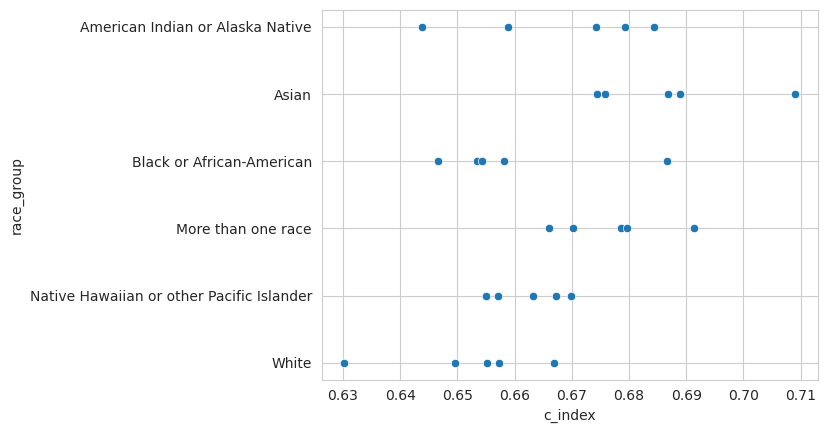

In [10]:
# Scatterplot of accuracy for each race group
# across 5-fold cross validation
results_by_race = pd.DataFrame(results_dicts)
to_plot = results_by_race.melt()
to_plot = to_plot.rename(columns={"variable":"race_group", "value":"c_index"})
sns.scatterplot(to_plot, y='race_group', x='c_index')
plt.show()

In [11]:
# Now try fitting the model on the entire training set.
pipeline = create_pipeline()

X_train_proc = pd.DataFrame(pipeline.fit_transform(df_proc[feat_names]), columns=pipeline.get_feature_names_out())
y_train_proc = df_proc[target_names]
train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

cph = CoxPHFitter()

cph.fit(train_proc, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>

In [12]:
# Examine model metrics and coefficients
# for the cox model fit on the entire 
# training set.
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 23040
number of events observed = 12428
   partial log-likelihood = -118077.64
         time fit was run = 2025-04-10 20:29:18 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
dri_score_High - TED AML case <missing cytogenetics         -0.36      0.70      0.05           -0.44           -0.27                0.64                0.77
dri_score_Intermediate                                      -0.44      0.64      0.03           -0.49           -0.39                0.61                0.68
dri_score_Intermediate - TED AML case <missing cytogenetics -0.34      0.71      0.07           -0.48           -0.20                0.62                0.82
dri_score_Low                                               -0.34      0.71      0.04           -0.42           -0.26                0.66                0.77
dri_score_N/A - disease not classifiable                    -0.49      0.62      0.11           -0.71           -0.26                0.49                0.77
dri_score_N/A - non-malignant indication                    -0.38      0.69      0.04           -0.46           -0.29                0.63                0.75
dri_score_N/A - pediatric                                   -0.38      0.69      0.03           -0.44           -0.31                0.64                0.74
dri_score_TBD cytogenetics                                  -0.28      0.75      0.05           -0.37           -0.19                0.69                0.83
dri_score_Very high                                         -0.23      0.79      0.13           -0.49            0.02                0.61                1.03
dri_score_nan                                               -0.62      0.54      0.13           -0.89           -0.36                0.41                0.70
psych_disturb_Not done                                       0.01      1.01      0.13           -0.25            0.26                0.78                1.30
psych_disturb_Yes                                            0.03      1.03      0.03           -0.02            0.09                0.98                1.09
psych_disturb_nan                                            0.09      1.10      0.06           -0.02            0.20                0.98                1.22
cyto_score_Intermediate                                      0.14      1.15      0.04            0.07            0.21                1.07                1.23
cyto_score_Normal                                            0.24      1.27      0.07            0.11            0.36                1.12                1.44
cyto_score_Not tested                                        0.04      1.04      0.20           -0.36            0.44                0.70                1.55
cyto_score_Other                                             0.25      1.28      0.07            0.10            0.39                1.11                1.48
cyto_score_Poor                                              0.22      1.25      0.03            0.15            0.29                1.16                1.33
cyto_score_TBD                                               0.23      1.26      0.05            0.13            0.33                1.13                1.39
cyto_score_nan                                               0.22      1.24      0.05            0.13            0.31                1.13                1.36
diabetes_Not done                                           -0.55      0.57      0.16           -0.87           -0.24                0.42                0

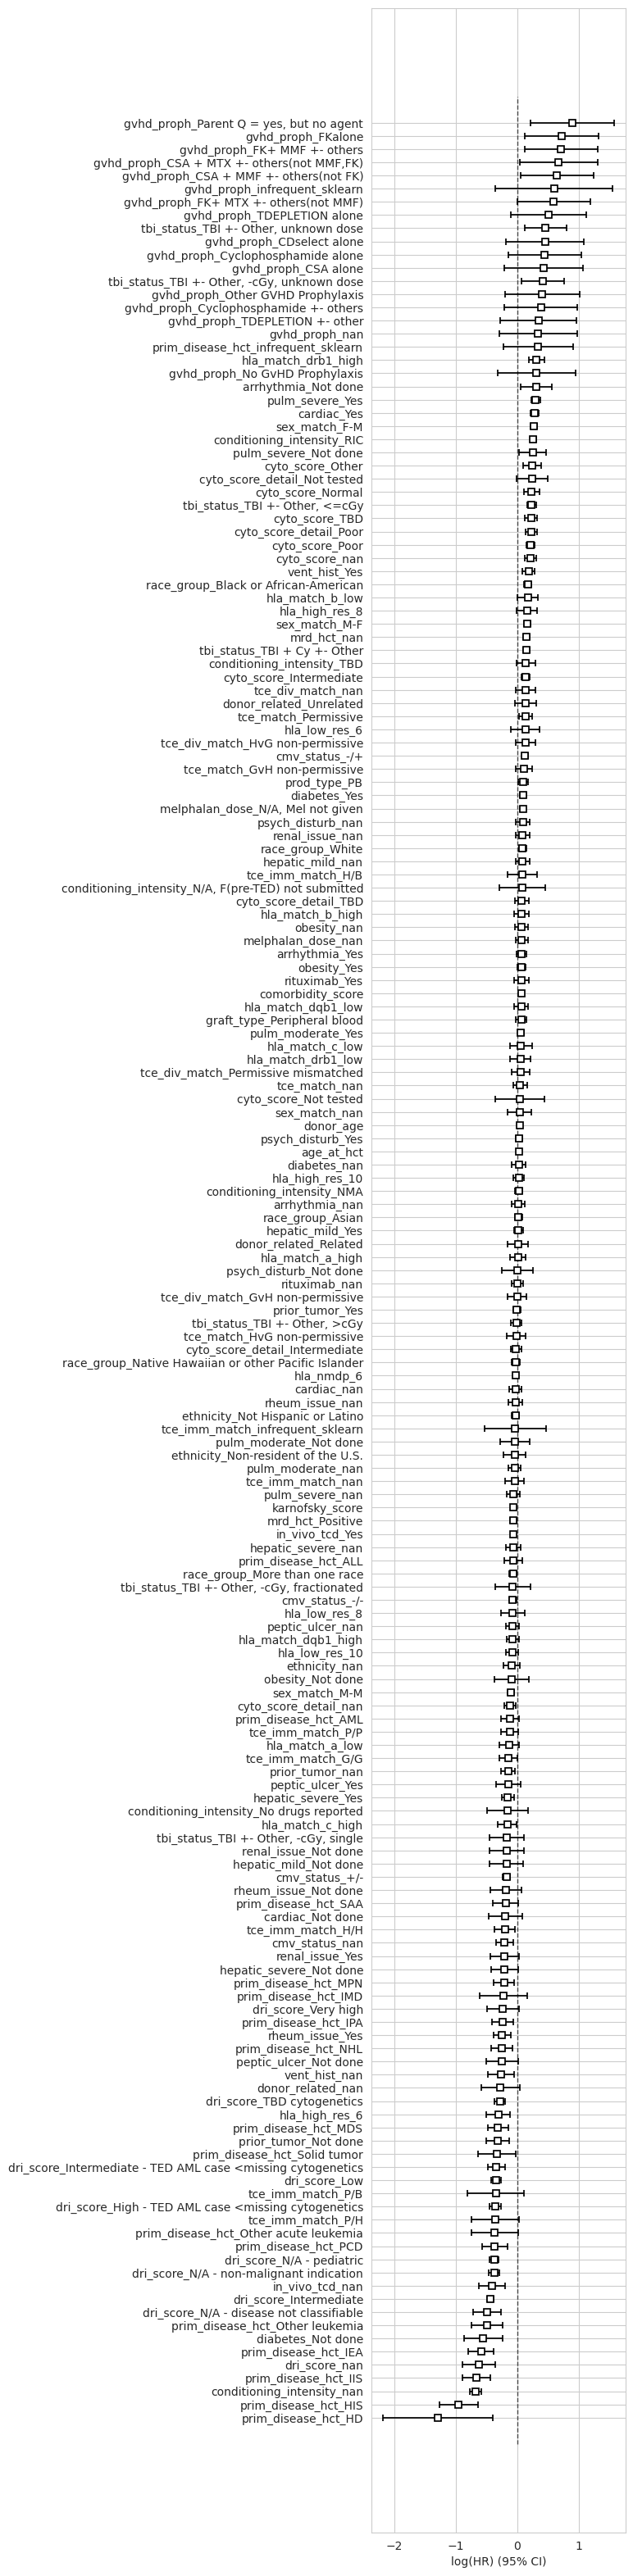

In [13]:
# Plot model coefficients from largest to smallest, with error bars.
# Notice that this model appears quite "noisy".
# Confidence intervals for many coefficients are quite wide,
# and may include zero.
# There are also many coefficients that are 
# close to zero, indicating that feature
# has very little impact.
plt.figure(figsize=(4, 40))
cph.plot()
plt.show()

### Drop Features Whose Coefficients Were Not Significant

In [14]:
# Create a dataframe of coefficients from the
# "out of the box" model.
# Add a column 'zero not in conf int' which records
# whether the confidence interval for the interval contains 0.
# If the confidence interval contains zero, that means
# we cannot say with 95% confidence that the feature
# has a non-zero impact on survival.
coefficient_info = pd.concat([cph.params_, cph.confidence_intervals_], axis=1).reset_index()
coefficient_info['abs_coef'] = abs(coefficient_info['coef'])
coefficient_info['zero not in conf int'] = coefficient_info['95% lower-bound'] * coefficient_info['95% upper-bound'] > 0

In [15]:
significant_coefs = coefficient_info.loc[coefficient_info['zero not in conf int']]
print("There are {} statistically significant coefficients".format(significant_coefs.shape[0]))

There are 78 statistically significant coefficients


In [16]:
# Convenience function to create a pipeline that
# scales a passed-in list of numeric features,
# then uses a KNN-imputer to impute any missing data.
# Note that this time, we're not including the
# one-hot encoding in the pipeline, since we are
# dropping features after encoding.

def no_enc_pipeline(to_scale = ['donor_age', 'age_at_hct', 'karnofsky_score']):
    pipeline = Pipeline(
        [
            (
                "scale",
                ColumnTransformer(
                    [
                        ('scale', StandardScaler(), to_scale)
                    ],
                    sparse_threshold=0,
                    remainder='passthrough',
                    verbose_feature_names_out=False,
                    force_int_remainder_cols=False
                )
            ),
            (
                "impute",
                KNNImputer()
            ),
        ]
    )

    return pipeline

In [17]:
# Repeat the 5-fold cross-validation with an 
# 'out of the box' Cox model, but this time
# drop all features whose coefficients were not 
# statistically signficant during the first experiment.
# Note that in general, this may not be best practice
# for feature selection: the goal here is 
# simply a rough first pass to see if we get
# comparable performance with a much
# smaller set of features.

feat_names = df_proc.columns[:-2]
target_names = ['efs', 'efs_time']

cat_cols = list(df_proc.select_dtypes(include='O').columns)
key_columns = significant_coefs.covariate.to_list() + ['efs', 'efs_time']
scale_key = [col for col in ['donor_age', 'age_at_hct', 'karnofsky_score'] if col in key_columns]

n_splits=5
kfold = KFold(n_splits=n_splits, shuffle=True)
c_indexes = np.zeros(n_splits)
scores = np.zeros(n_splits)
results_dicts = []

for num, (train_idx, test_idx) in enumerate(kfold.split(df_proc)):
    
    print("Starting fold", num)
    train = df_proc.iloc[train_idx]
    test = df_proc.iloc[test_idx]
    
    just_enc = ColumnTransformer(
                    [
                        ('one_hot', 
                        OneHotEncoder(drop='first',
                                      min_frequency = 0.001,
                                      handle_unknown='ignore',
                        ), 
                        cat_cols
                        ),
                    ],
                    sparse_threshold=0,
                    remainder='passthrough',
                    verbose_feature_names_out=False,
                    force_int_remainder_cols=False
                )

    pipeline = no_enc_pipeline(scale_key)

    X_train_enc = pd.DataFrame(just_enc.fit_transform(train[feat_names]), columns=just_enc.get_feature_names_out()).set_index(train_idx)
    keep_features = [col for col in X_train_enc.columns.to_list() if col in key_columns]
    X_train_drop = X_train_enc[keep_features]
    
    X_train_proc = pd.DataFrame(pipeline.fit_transform(X_train_drop), 
                                columns=pipeline.get_feature_names_out()).set_index(train_idx)
    
    y_train_proc = train[target_names]
    train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

    X_test_enc = pd.DataFrame(just_enc.transform(test[feat_names]), columns=just_enc.get_feature_names_out()).set_index(test_idx)
    X_test_drop = X_test_enc[keep_features]

    X_test_proc = pd.DataFrame(pipeline.fit_transform(X_test_drop), 
                              columns=pipeline.get_feature_names_out()).set_index(test_idx)

    y_test_proc = test[target_names]
    test_proc = pd.concat([X_test_proc, y_test_proc], axis=1)

    cph = CoxPHFitter()
    cph.fit(train_proc, duration_col='efs_time', event_col='efs')

    preds = cph.predict_partial_hazard(test_proc)

    solution = hct_df.iloc[test_idx]
    prediction = pd.DataFrame({"ID":hct_df.iloc[test_idx]["ID"], "prediction":preds})
    scores[num] = score(solution.copy(deep=True), prediction.copy(deep=True), "ID")
    c_indexes[num] = concordance_index(y_test_proc['efs_time'], -preds, y_test_proc['efs'])
    results_dicts.append(get_result_by_race(solution.copy(deep=True), prediction.copy(deep=True), "ID"))
    
print(scores)

Starting fold 0
Starting fold 1


/home/raykarpman/anaconda3/envs/erdos_sp25_post_hct/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Starting fold 2
Starting fold 3
Starting fold 4
[0.64698286 0.64181956 0.65604972 0.65612518 0.64312547]


In [18]:
print(c_indexes)

[0.6722151  0.66578629 0.66542911 0.67748785 0.66045174]


In [19]:
print(np.mean(c_indexes))

0.668274018014936


In [20]:
# Average the cross-validated scores. 
# It seems that dropping non-signficiant 
# predictors had a negligable impact on performance.
np.mean(scores)

np.float64(0.6488205586030182)

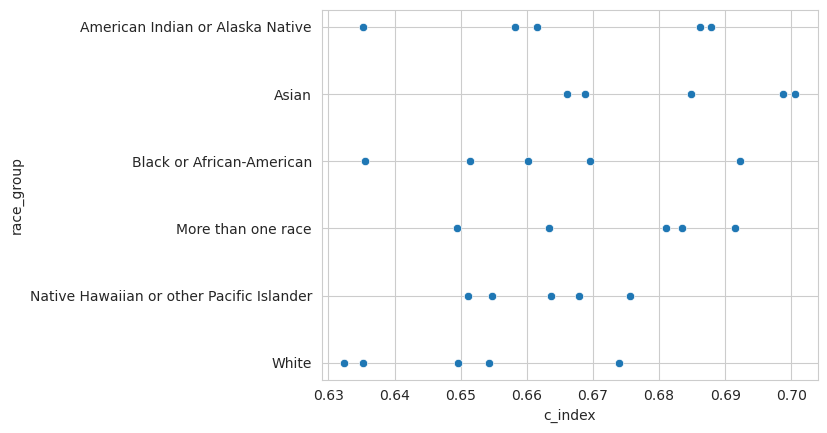

In [21]:
# Scatterplot of accuracy for each race group
# across 5-fold cross validation
results_by_race = pd.DataFrame(results_dicts)
to_plot = results_by_race.melt()
to_plot = to_plot.rename(columns={"variable":"race_group", "value":"c_index"})
sns.scatterplot(to_plot, y='race_group', x='c_index')
plt.show()

In [22]:
# Now refit the model to the entire training set,
# again only using features that were significant 
# on the first attempt.
# This allows us to easily compare
# and plot coefficients for the model
# with the smaller set of features.

feat_names = df_proc.columns[:-2]
target_names = ['efs', 'efs_time']

cat_cols = list(df_proc.select_dtypes(include='O').columns)
key_columns = significant_coefs.covariate.to_list() + ['efs', 'efs_time']
scale_key = [col for col in ['donor_age', 'age_at_hct', 'karnofsky_score'] if col in key_columns]

just_enc = ColumnTransformer(
                    [
                        ('one_hot', 
                        OneHotEncoder(drop='first',
                                      min_frequency = 0.001,
                                      handle_unknown='ignore',
                        ), 
                        cat_cols
                        ),
                    ],
                    sparse_threshold=0,
                    remainder='passthrough',
                    verbose_feature_names_out=False,
                    force_int_remainder_cols=False
                )

pipeline = no_enc_pipeline(scale_key)

X_train_enc = pd.DataFrame(just_enc.fit_transform(df_proc[feat_names]), columns=just_enc.get_feature_names_out())
keep_features = [col for col in X_train_enc.columns.to_list() if col in key_columns]
X_train_drop = X_train_enc[keep_features]
    
X_train_proc = pd.DataFrame(pipeline.fit_transform(X_train_drop), 
                            columns=pipeline.get_feature_names_out())
    
y_train_proc = df_proc[target_names]
train_proc = pd.concat([X_train_proc, y_train_proc], axis=1)

cph_sig = CoxPHFitter()
cph_sig.fit(train_proc, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>

In [23]:
# Examine the metric and coefficients for the model
# with the restricted feature set.
cph_sig.print_summary()

<lifelines.CoxPHFitter: fitted with 23040 total observations, 10612 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 23040
number of events observed = 12428
   partial log-likelihood = -118208.44
         time fit was run = 2025-04-10 20:34:08 UTC

---
                                                             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                    
donor_age                                                    0.02      1.02      0.01           -0.00            0.04                1.00                1.04
age_at_hct                                                   0.03      1.04      0.01            0.01            0.06                1.01                1.06
karnofsky_score                                             -0.06      0.94      0.01           -0.08           -0.04                0.93                0.96
dri_score_High - TED AML case <missing cytogenetics         -0.36      0.70      0.04           -0.45           -0.27                0.64                0.76
dri_score_Intermediate                                      -0.43      0.65      0.03           -0.48           -0.38                0.62                0.68
dri_score_Intermediate - TED AML case <missing cytogenetics -0.33      0.72      0.07           -0.47           -0.19                0.63                0.83
dri_score_Low                                               -0.33      0.72      0.04           -0.41           -0.25                0.67                0.78
dri_score_N/A - disease not classifiable                    -0.49      0.61      0.11           -0.71           -0.26                0.49                0.77
dri_score_N/A - non-malignant indication                    -0.38      0.68      0.04           -0.46           -0.30                0.63                0.74
dri_score_N/A - pediatric                                   -0.37      0.69      0.03           -0.44           -0.31                0.64                0.74
dri_score_TBD cytogenetics                                  -0.28      0.75      0.05           -0.37           -0.19                0.69                0.82
dri_score_nan                                               -0.62      0.54      0.13           -0.88           -0.36                0.41                0.70
cyto_score_Intermediate                                      0.13      1.14      0.03            0.07            0.20                1.07                1.22
cyto_score_Normal                                            0.24      1.27      0.06            0.12            0.37                1.12                1.45
cyto_score_Other                                             0.25      1.28      0.07            0.11            0.39                1.11                1.48
cyto_score_Poor                                              0.22      1.25      0.03            0.16            0.29                1.17                1.33
cyto_score_TBD                                               0.24      1.28      0.05            0.14            0.34                1.16                1.41
cyto_score_nan                                               0.18      1.20      0.04            0.10            0.27                1.10                1.31
diabetes_Not done                                           -0.58      0.56      0.16           -0.89           -0.27                0.41                0.76
diabetes_Yes                                                 0.09      1.10      0.02            0.05            0.14                1.05                1.15
tbi_status_TBI + Cy +- Other                                 0.17      1.18      0.02            0.12            0.21                1.12                1

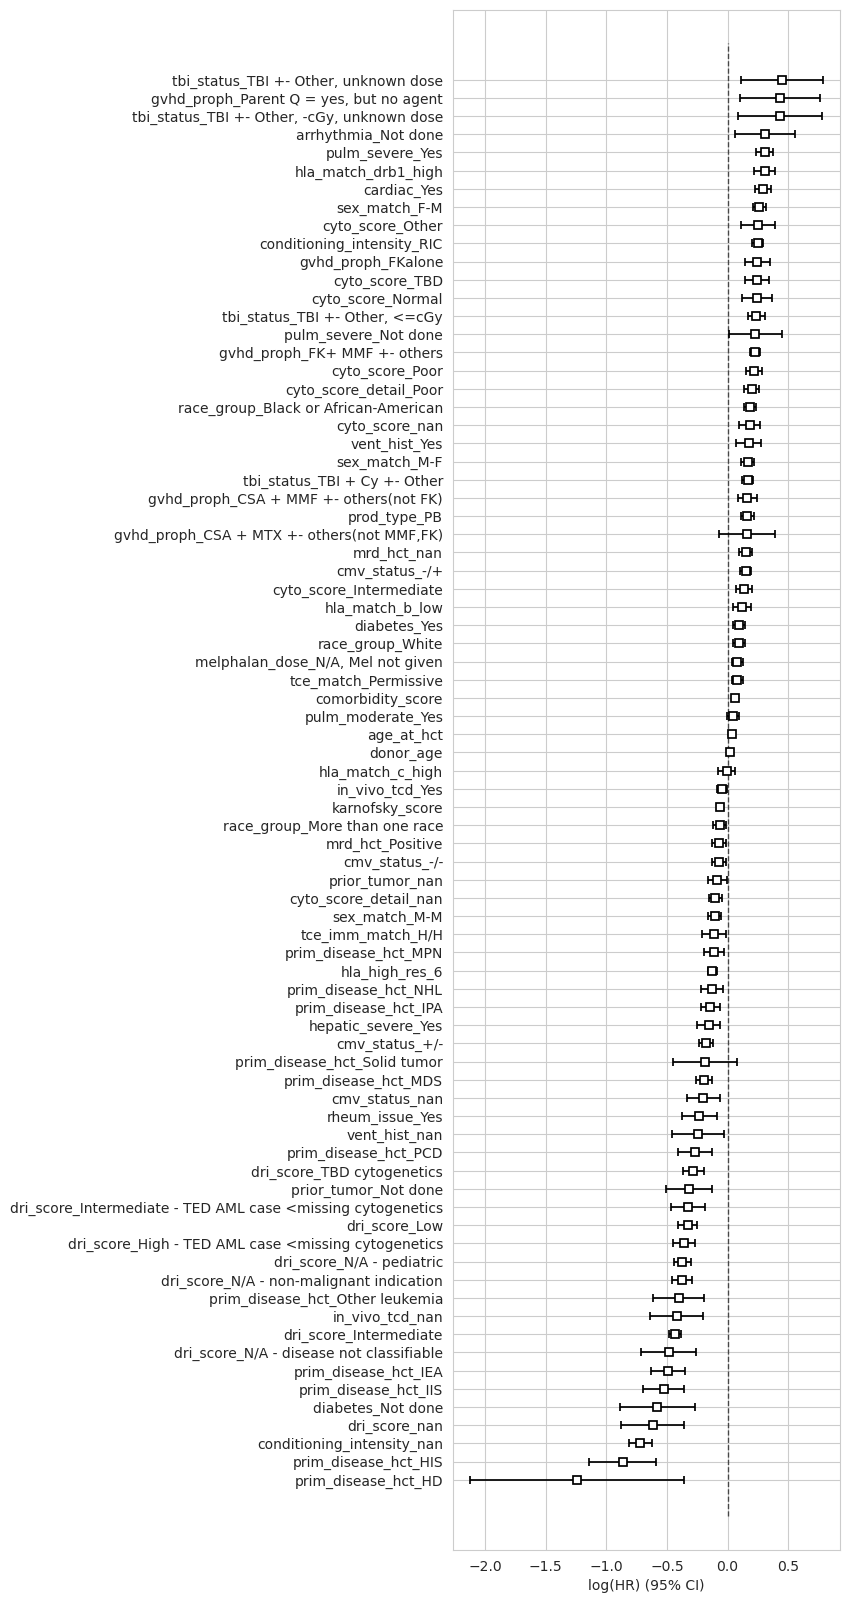

In [24]:
# Plot coeffients for Cox model with 
# a smaller set of features. 
# Notice there are still many features
# with coefficients very close to 0,
# and a few whose confidence intervals 
# even include 0. 
# It is likely that we could reduce the feature
# set much more without harming performance.
plt.figure(figsize=(5, 20))
cph_sig.plot()
plt.show()